In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 
from torch.distributions import Independent, Normal

PRINT_REQ= False

In [2]:
batch_size = 32
device="cuda" if torch.cuda.is_available() else "cpu"
train_data = datasets.MNIST(root="../data", train=True, 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(root="../data", train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [3]:
def print_debug(data):
    if PRINT_REQ:
        print(data)
    else:
        pass

In [4]:
class_names=train_data.classes
class_to_idx = train_data.class_to_idx
import torch.nn.functional as F

In [63]:
class Encoder(nn.Module):
    def __init__(self, dim_x, dim_y, dim_z):

        super().__init__()
         # Encoder layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1,padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2,padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1,padding='same')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2,padding=0)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=80, kernel_size=7, stride=1,padding='valid')
        self.lin1 = nn.Linear(in_features=90, out_features=20)
        self.lin2 = nn.Linear(in_features=90, out_features=20)

        # reparameterization
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, inputs):
        x = inputs[0].to(device)#.unsqueeze(dim=0)
        y = inputs[1].to(device)
        print(f"img shape: {x.shape}, labels shape: {y.shape}")
        x = F.leaky_relu(self.conv1(x))
        print_debug(x.shape)
        # 32, 28, 28
        x = F.pad(x, (0,3,0,3))
        print_debug(x.shape)
        # 32, 31, 31
        x = F.leaky_relu(self.conv2(x))
        print_debug(x.shape)
        # 32, 14, 14
        x = F.leaky_relu(self.conv3(x))
        print_debug(x.shape)
        # 64, 14, 14
        x = F.pad(x, (0,3,0,3))
        print_debug(x.shape)
        # 64, 17, 17
        x = F.leaky_relu(self.conv4(x))
        print_debug(x.shape)
        # 64, 7, 7
        x = F.leaky_relu(self.conv5(x))
        print_debug(x.shape)
        # 80, 1, 1
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        print_debug(f"After flatten shape: {x.shape}")
        # 80
        print(x.shape, y.shape)
        concat = torch.cat([x, y], dim=1)
        print_debug(f"After concatenation shape: {concat.shape}")
        # 90
        # loc=torch.zeros(mu_logvar.shape)
        # scale=torch.ones(mu_logvar.shape)
        # diagn = Independent(Normal(loc, scale), 1)
        mu = self.lin1(concat)
        print_debug(f"mu shape: {mu.shape}")
        # 20
        logvar = self.lin2(concat)
        print_debug(f"logvar shape: {logvar.shape}")
        z = self.reparameterize(mu, logvar)
        print_debug(f"Returning shape {z.shape}")
        return  mu, logvar, z

In [64]:
class Decoder(nn.Module):
    def __init__(self, dim_y, dim_z):
        super().__init__()
        self.dim_z = dim_z
        self.dim_y = dim_y
        self.deconv1 = nn.ConvTranspose2d(in_channels=30, out_channels=64, kernel_size=7, stride=1, padding=0) # valid means no pad
        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=2, output_padding=1) # pad operation added in forward
        self.deconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.deconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=1) # pad operation added in forward
        self.deconv6 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1,padding='same')
        

    def forward(self, inputs):
        x = inputs[0].to(device)#.unsqueeze(dim=0)
        y = inputs[1].to(device)
        print_debug(f"latent space shape: {x.shape}, labels shape: {y.shape}")
        x = torch.cat([x, y], dim=1)
        x = torch.reshape(x, (-1, self.dim_z+self.dim_y, 1, 1))
        print_debug(f"After concatenation shape: {x.shape}")
        x = F.leaky_relu(self.deconv1(x))
        print_debug(f"ConvTrans1 output shape: {x.shape}")
        x = F.leaky_relu(self.deconv2(x))
        print_debug(f"ConvTrans2 output shape: {x.shape}")
        x = F.pad(x, (0,0,0,0))
        x = F.leaky_relu(self.deconv3(x))
        print_debug(f"ConvTrans3 output shape: {x.shape}")
        x = F.leaky_relu(self.deconv4(x))
        print_debug(f"ConvTrans4 output shape: {x.shape}")
        # x = F.pad(x, (0,3,0,3))
        x = F.leaky_relu(self.deconv5(x))
        print_debug(f"ConvTrans5 output shape: {x.shape}")
        x = F.leaky_relu(self.deconv6(x))
        print_debug(f"ConvTrans6 output shape: {x.shape}")
        x = torch.sigmoid(self.conv(x))
        print_debug(f"Conv output shape: {x.shape}")
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        print_debug(f"After flatten shape: {x.shape}")
        return x

In [65]:
class CVAE(nn.Module):
    def __init__(self, dim_x, dim_y, dim_z):
        super().__init__()

        #Encoder 
        self.encoder = Encoder(dim_x=dim_x, dim_y=dim_y, dim_z=dim_z)

        #Decoder
        self.decoder = Decoder(dim_y=dim_y, dim_z=dim_z)

    def forward(self, inputs):
        x, y = inputs        
        print_debug(f"Inputs shape: {x.shape} and labels: {y.shape}")
        mu, logvar, z = self.encoder((x,y))
        out = self.decoder((z, y))
        print_debug(f"decoder output shape is: {out.shape}")
        return mu, logvar, out


   


In [66]:
model = CVAE(dim_x=(28, 28, 1), dim_y=10, dim_z=20).to(device)

optimizer = torch.optim.Adam(model.parameters())

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [61]:
# Testing the architecture by sending one batch of data through CVAE
for i, (x, y) in enumerate(train_dataloader):
    y = F.one_hot(y, 10)
    model((x,y))
    break

torch.Size([32, 80]) torch.Size([32, 10])


In [10]:
# Download helper functions
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

import helper_functions

helper_functions.py already exists, skipping download


In [11]:
def train_step():
    train_loss = 0
    train_acc = 0
    # Train step
    for batch, (X,y) in enumerate(train_dataloader):
        # print(f"Batch: {batch+1}/{len(train_dataloader)}")
        X = x.to(device)
        y = F.one_hot(y, 10).to(device)
        model.train()
        #Forward pass
        mu, logvar, y_pred = model((X,y))


        #Loss
        loss = loss_function(recon_x=y_pred, x=X, mu=mu, log_var=logvar)
        

        #zero grad
        optimizer.zero_grad()

        #backprop
        loss.backward()
        train_loss += loss.item()

        #step
        optimizer.step()

        # if batch % 600 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch+1, batch * len(X), len(train_dataloader.dataset),
        #         100. * batch / len(train_dataloader), loss.item() / len(X)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch+1, train_loss / len(train_dataloader.dataset)))

def test_step():
    #Test step
    model.eval()
    test_loss= 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            # print(f"batch {batch+1}/{len(test_dataloader)}")
            X = X.to(device)
            y = F.one_hot(y, 10).to(device)
            mu, logvar, ypred = model((X, y))
            # sum up batch loss
            test_loss += loss_function(ypred, X, mu, logvar).item()

    test_loss /= len(test_dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
        


In [12]:
torch.manual_seed(42)

epochs=5

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}\n---------")
    train_step()
    test_step()
print("End Training")
    

Epoch: 1
---------
====> Epoch: 1 Average loss: 83.9061
====> Test set loss: 297.1501
Epoch: 2
---------
====> Epoch: 2 Average loss: 56.2639
====> Test set loss: 336.9322
Epoch: 3
---------
====> Epoch: 3 Average loss: 54.7321
====> Test set loss: 354.8426
Epoch: 4
---------
====> Epoch: 4 Average loss: 54.1912
====> Test set loss: 331.6208
Epoch: 5
---------
====> Epoch: 5 Average loss: 56.4100
====> Test set loss: 389.7023
End Training


In [30]:
def one_hot(labels, class_size): 
    targets = torch.zeros(len(labels), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [68]:
img=train_data[0][0].unsqueeze(dim=1)
img.shape
c = torch.eye(10).cuda()
lbl = c[4].unsqueeze(dim=0)
print(img.shape, lbl.shape)
model.eval()
with torch.inference_mode():
    _, _, recon=model((img, lbl))


# lbl=one_hot(lbl, 10)
# lbl.shape

torch.Size([1, 1, 28, 28]) torch.Size([1, 10])
img shape: torch.Size([1, 1, 28, 28]), labels shape: torch.Size([1, 10])
torch.Size([1, 80]) torch.Size([1, 10])


In [75]:
recon=recon.reshape([1,1,28,28])
recon=recon.cpu()
recon.shape

torch.Size([1, 1, 28, 28])

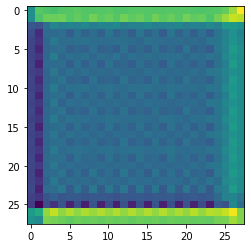

In [76]:
plt.imshow(recon[0].squeeze())

In [53]:
c[4].unsqueeze(dim=0).shape

torch.Size([1, 10])

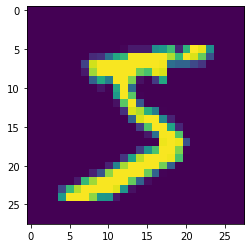

In [45]:
plt.imshow(img[0].squeeze())